In [1]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

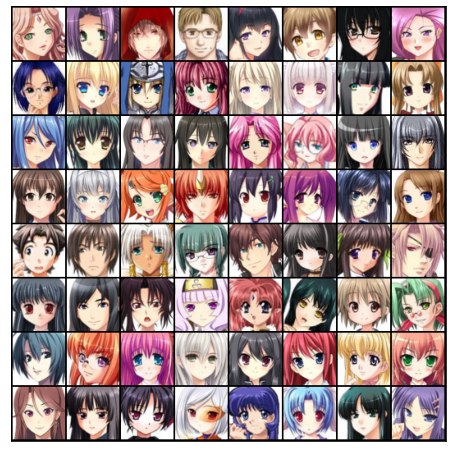

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda', index=0)

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


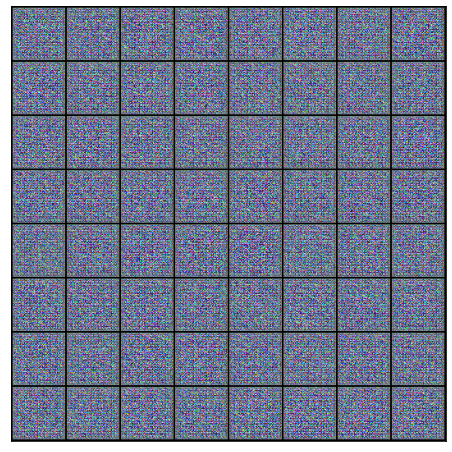

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


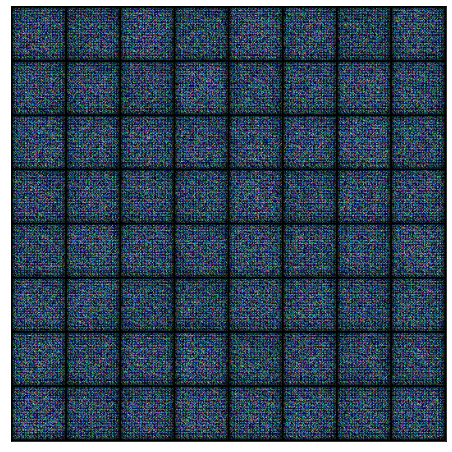

In [26]:
save_samples(0, fixed_latent)

In [27]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 25

In [30]:
import jovian
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

<IPython.core.display.Javascript object>

[jovian] Hyperparams logged.


In [31]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 3.4458, loss_d: 0.8952, real_score: 0.5003, fake_score: 0.0053
Saving generated-images-0001.png



Epoch [2/25], loss_g: 6.2993, loss_d: 0.7256, real_score: 0.9848, fake_score: 0.4471
Saving generated-images-0002.png



Epoch [3/25], loss_g: 5.2179, loss_d: 0.2211, real_score: 0.8972, fake_score: 0.0892
Saving generated-images-0003.png



Epoch [4/25], loss_g: 6.5373, loss_d: 0.1011, real_score: 0.9562, fake_score: 0.0457
Saving generated-images-0004.png



Epoch [5/25], loss_g: 4.5137, loss_d: 0.3737, real_score: 0.8257, fake_score: 0.0989
Saving generated-images-0005.png



Epoch [6/25], loss_g: 6.2486, loss_d: 0.1348, real_score: 0.9230, fake_score: 0.0385
Saving generated-images-0006.png



Epoch [7/25], loss_g: 6.2250, loss_d: 0.1134, real_score: 0.9223, fake_score: 0.0209
Saving generated-images-0007.png



Epoch [8/25], loss_g: 6.4185, loss_d: 0.1138, real_score: 0.9593, fake_score: 0.0633
Saving generated-images-0008.png



Epoch [9/25], loss_g: 4.3755, loss_d: 0.0764, real_score: 0.9770, fake_score: 0.0472
Saving generated-images-0009.png



Epoch [10/25], loss_g: 10.3819, loss_d: 0.2733, real_score: 0.9799, fake_score: 0.2027
Saving generated-images-0010.png



Epoch [11/25], loss_g: 11.0288, loss_d: 0.3687, real_score: 0.9643, fake_score: 0.2501
Saving generated-images-0011.png



Epoch [12/25], loss_g: 5.7278, loss_d: 0.1265, real_score: 0.9500, fake_score: 0.0657
Saving generated-images-0012.png



Epoch [13/25], loss_g: 4.5608, loss_d: 0.2297, real_score: 0.8680, fake_score: 0.0548
Saving generated-images-0013.png



Epoch [14/25], loss_g: 5.1519, loss_d: 0.0977, real_score: 0.9660, fake_score: 0.0538
Saving generated-images-0014.png



Epoch [15/25], loss_g: 5.1574, loss_d: 0.1319, real_score: 0.9562, fake_score: 0.0754
Saving generated-images-0015.png



Epoch [16/25], loss_g: 4.5274, loss_d: 0.1214, real_score: 0.9221, fake_score: 0.0114
Saving generated-images-0016.png



Epoch [17/25], loss_g: 7.4736, loss_d: 0.1771, real_score: 0.9882, fake_score: 0.1378
Saving generated-images-0017.png



Epoch [18/25], loss_g: 5.5486, loss_d: 0.1308, real_score: 0.9566, fake_score: 0.0746
Saving generated-images-0018.png



Epoch [19/25], loss_g: 4.0407, loss_d: 0.1019, real_score: 0.9370, fake_score: 0.0273
Saving generated-images-0019.png



Epoch [20/25], loss_g: 5.8732, loss_d: 0.0848, real_score: 0.9479, fake_score: 0.0251
Saving generated-images-0020.png



Epoch [21/25], loss_g: 5.1668, loss_d: 0.1816, real_score: 0.9424, fake_score: 0.0975
Saving generated-images-0021.png



Epoch [22/25], loss_g: 3.8783, loss_d: 0.1463, real_score: 0.9101, fake_score: 0.0396
Saving generated-images-0022.png



Epoch [23/25], loss_g: 3.6082, loss_d: 0.2663, real_score: 0.8109, fake_score: 0.0105
Saving generated-images-0023.png



Epoch [24/25], loss_g: 5.9853, loss_d: 0.2753, real_score: 0.8155, fake_score: 0.0032
Saving generated-images-0024.png



Epoch [25/25], loss_g: 3.8830, loss_d: 0.1460, real_score: 0.9023, fake_score: 0.0188
Saving generated-images-0025.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = history

iou değeri = doğru olması gerek alan / hem doğru hem tahmin değerinin tamamı

tensorboard elinizdeki verilerin görüntülemede kullanılır

In [33]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [34]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

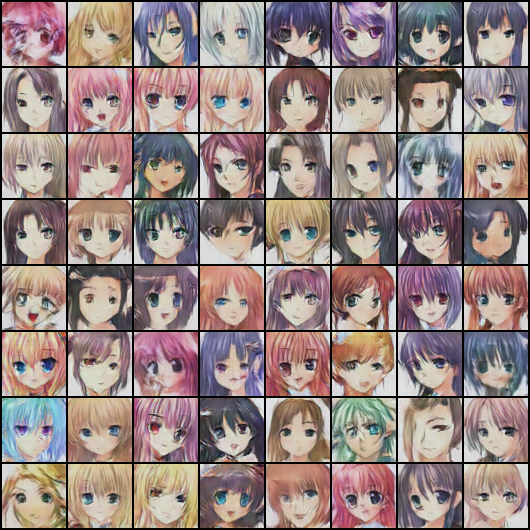

In [37]:
from IPython.display import Image
Image('./generated/generated-images-0025.png')

Her dönemden sonra oluşturulan örnek görüntüleri OpenCV kullanarak bir videoda birleştirerek eğitim sürecini görselleştirebiliriz.

In [39]:
import cv2
import os

vid_fname = 'gans_anime.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]#for a kadar olan kısım f içine her bir resmi sokar
files.sort()
files

['generated\\generated-images-0000.png',
 'generated\\generated-images-0001.png',
 'generated\\generated-images-0002.png',
 'generated\\generated-images-0003.png',
 'generated\\generated-images-0004.png',
 'generated\\generated-images-0005.png',
 'generated\\generated-images-0006.png',
 'generated\\generated-images-0007.png',
 'generated\\generated-images-0008.png',
 'generated\\generated-images-0009.png',
 'generated\\generated-images-0010.png',
 'generated\\generated-images-0011.png',
 'generated\\generated-images-0012.png',
 'generated\\generated-images-0013.png',
 'generated\\generated-images-0014.png',
 'generated\\generated-images-0015.png',
 'generated\\generated-images-0016.png',
 'generated\\generated-images-0017.png',
 'generated\\generated-images-0018.png',
 'generated\\generated-images-0019.png',
 'generated\\generated-images-0020.png',
 'generated\\generated-images-0021.png',
 'generated\\generated-images-0022.png',
 'generated\\generated-images-0023.png',
 'generated\\gen

In [40]:
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))#video özelliklerimiz
[out.write(cv2.imread(fname)) for fname in files]#files içindeki frameleri video dosyasına veriyoruz
out.release()#videoyu yayınla

In [45]:
for f in os.listdir(sample_dir) :
    if 'generated' in f:
        print(f)

generated-images-0000.png
generated-images-0001.png
generated-images-0002.png
generated-images-0003.png
generated-images-0004.png
generated-images-0005.png
generated-images-0006.png
generated-images-0007.png
generated-images-0008.png
generated-images-0009.png
generated-images-0010.png
generated-images-0011.png
generated-images-0012.png
generated-images-0013.png
generated-images-0014.png
generated-images-0015.png
generated-images-0016.png
generated-images-0017.png
generated-images-0018.png
generated-images-0019.png
generated-images-0020.png
generated-images-0021.png
generated-images-0022.png
generated-images-0023.png
generated-images-0024.png
generated-images-0025.png


In [46]:
os.path.join("a","b")#iki değeri birbirine ekler

'a\\b'


Kaybın zaman içinde nasıl değiştiğini de görselleştirebiliriz. Kayıpları görselleştirmek, eğitim sürecinde hata ayıklamak için oldukça kullanışlıdır. GAN'lar için, discriminator kaybı çok yüksek olmadan, generator kaybının zaman içinde azalmasını bekliyoruz.

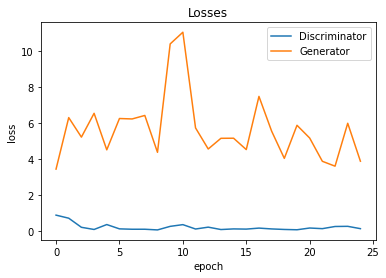

In [47]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

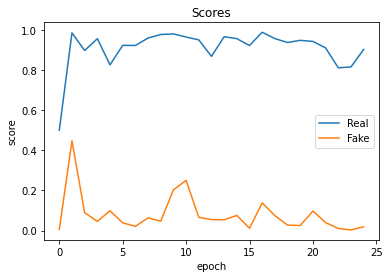

In [48]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [51]:
jovian.commit(project='06b-anime-dcgan', 
              outputs=['./Models/G.pth', './Models/D.pth', './generated/gans_training.avi'], 
              environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "tolgaisikp/06b-anime-dcgan" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...


[jovian] Error: Ignoring "./generated/gans_training.avi" (not found)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tolgaisikp/06b-anime-dcgan


'https://jovian.ai/tolgaisikp/06b-anime-dcgan'